In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [299]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''
from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
import beamline34IDC.optimization.movers as movers
from beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob
import IPython
import gym
from stable_baselines3 import PPO

In [273]:
class CustomOptimization(opt_common.OptimizationCommon):
    def _optimize(self):
        pass
    
    def set_optimizer_options(self):
        pass
    
    def trials(self):
        pass
    

class CustomEnv(gym.Env):
    def __init__(self, focusing_system, motor_types, loss_parameters='centroid', random_seed=None):
        super().__init__()
        
        self.optimizer = CustomOptimization(focusing_system, motor_types, random_seed=random_seed, loss_parameters=loss_parameters)
        
        #action_space_lows = []
        #action_space_highs = []
        #obs_space_lows = []
        #obs_space_highs = []
        obs_space_maxes = []
        obs_space_origs = []
        resolutions = []
        
        for mt in self.optimizer.motor_types:
            obs_space_float = configs.DEFAULT_MOVEMENT_RANGES[mt]
            res = configs.DEFAULT_MOTOR_RESOLUTIONS[mt]
            
            #act = 10 * res
            #action_space_lows.append(-act)
            #action_space_highs.append(act)
            #obs_space_lows.append(obs_space_float[0])
            #obs_space_highs.append(obs_space_float[1])
            
            obs_space_int = (np.array(obs_space_float) / res).astype('int')
            obs_space_max = obs_space_int[1] - obs_space_int[0]
            obs_space_orig = obs_space_max // 2
            obs_space_maxes.append(obs_space_max)
            obs_space_origs.append(obs_space_orig)
            resolutions.append(res)
            
        
        # Setting an action space of 20 steps (10 positive, 10 negative) for each motor.
        self.action_space = gym.spaces.MultiDiscrete([20] * len(self.optimizer.motor_types))
        self.action_space_origs = np.array([10] * len(self.optimizer.motor_types))
        
        self.observation_space = gym.spaces.MultiDiscrete(obs_space_maxes)
        self.observation_space_origs = np.array(obs_space_origs)
        
        self.resolutions = np.array(resolutions)
        self.absolute_pos = self.observation_space_origs
        
        #self.action_space = gym.spaces.Box(low=np.array(action_space_lows), high=np.array(action_space_highs))
        #self.action_space
        #self.observation_space = gym.spaces.Box(low=np.array(obs_space_lows), high=np.array(obs_space_highs))
        #self.absolute_pos = np.zeros(len(self.optimizer.motor_types))
        
        self.current_loss = self.optimizer.loss_function(0, verbose=False)
        self.current_reward = self.reward()
        self.counter = 0
        #print(self.absolute_pos)
        
    
    def step(self, action):
        #this gives the loss due to the relative motion "action"
        action_this = action - self.action_space_origs
        
        self.absolute_pos = self.absolute_pos + action_this
        
        self.current_loss = self.optimizer.loss_function(action_this * self.resolutions, verbose=False)
        self.counter += 1
        
        done = True if self.current_loss <= self.optimizer._loss_min_value else False
        info = {}
        print("Current loss is", self.current_loss, "for position", self.absolute_pos, "and action", action, "at", self.counter)
        return self.absolute_pos, self.reward(), done, info
    
    
    def reward(self):
        self.current_reward = 1 - self.current_loss
        return self.current_reward
    
    
    def reset(self):
        self.current_loss = self.optimizer.loss_function((self.observation_space_origs - self.absolute_pos) * self.resolutions, verbose=False)
        self.absolute_pos = self.observation_space_origs
        print("Current loss is", self.current_loss, "for position", self.absolute_pos, "at counter", self.counter)
        return self.absolute_pos
    


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

80562


In [5]:
!pwd

/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/work_directory/jupyter/gp_discrete


In [6]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [7]:
os.mkdir(temp_work_dir)

In [8]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [9]:
os.chdir(temp_work_dir)

In [10]:
input_beam_path = "primary_optics_system_beam.dat"

In [280]:
move_motors = ['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3']

In [329]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [330]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0. 0. 3. 3.]


In [334]:
test_random_movement = np.array([0.07, 0.02, 0.004, 0.00])
test_absolute_movements = initial_absolute_positions + test_random_movement
focusing_system = movers.move_motors(focusing_system, move_motors, test_absolute_movements, movement='absolute')

In [335]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
print('Initial loss is', centroid)

Initial loss is 0.08956711138978926


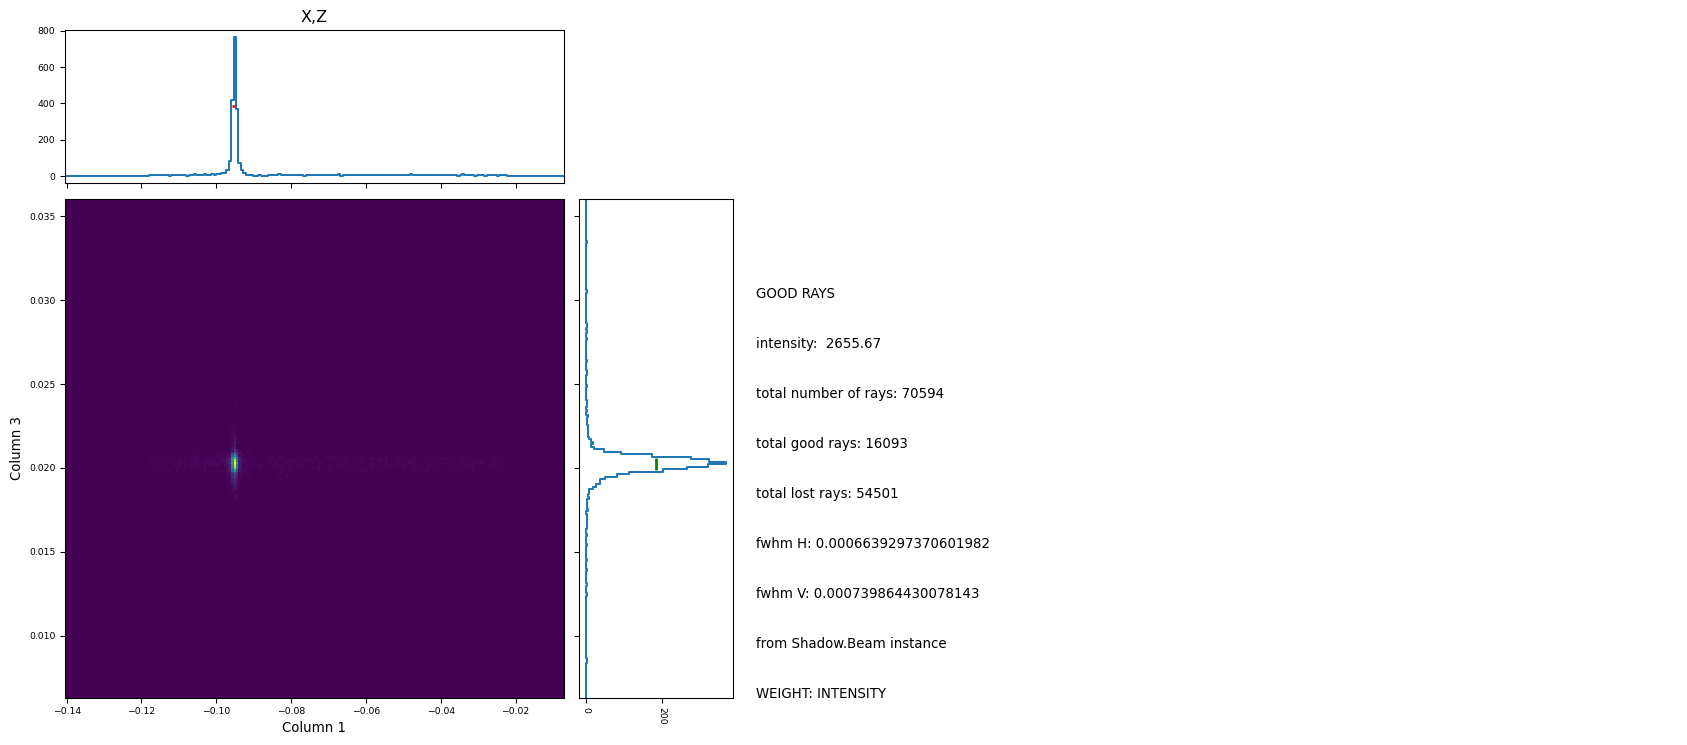

-0.0872518283221197


In [336]:
_ = plot_shadow_beam_spatial_distribution(out_beam)
print(dw.get_parameter('h_centroid'))

In [297]:
env = CustomEnv(focusing_system, move_motors, random_seed=DEFAULT_RANDOM_SEED, loss_parameters=['centroid', 'fwhm'])

In [ ]:
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048)
model.learn(total_timesteps=10)

In [271]:
obs = env.reset()

Current loss is 0.06984450871352048 for position [200] at counter 10


In [272]:
while True:
    action, _states = model.predict(obs, deterministic=True)
    print(action)
    obs, reward, done, info = env.step(action)

[11]
Action is [11] [200]
Current loss is 0.07084152430193735 for position [201] and action [11] at 11
[9]
Action is [9] [201]
Current loss is 0.06984450871352048 for position [200] and action [9] at 12
[11]
Action is [11] [200]
Current loss is 0.07084152430193735 for position [201] and action [11] at 13
[9]
Action is [9] [201]
Current loss is 0.06984450871352048 for position [200] and action [9] at 14
[11]
Action is [11] [200]
Current loss is 0.07084152430193735 for position [201] and action [11] at 15
[9]
Action is [9] [201]
Current loss is 0.06984450871352048 for position [200] and action [9] at 16
[11]
Action is [11] [200]
Current loss is 0.07084152430193735 for position [201] and action [11] at 17
[9]
Action is [9] [201]
Current loss is 0.06984450871352048 for position [200] and action [9] at 18
[11]
Action is [11] [200]
Current loss is 0.07084152430193735 for position [201] and action [11] at 19
[9]
Action is [9] [201]
Current loss is 0.06984450871352048 for position [200] and ac

KeyboardInterrupt: 

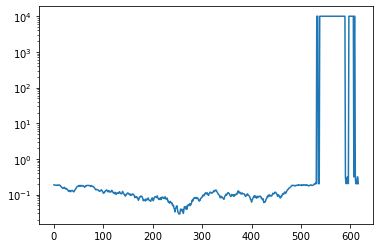

In [58]:
plt.plot(c.optimizer._opt_trials_losses)
plt.yscale('log')